In [25]:
import  matplotlib.pyplot as plt
import cv2
from scipy import ndimage
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

In [26]:
from cellpose import models
from cellpose.io import imread

# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=False, model_type='cyto3')

# Parachutes

In [55]:
path_dataset = os.path.join("..", "data", "2024_liang", "Parachute_1d_zoomed")
images_names = os.listdir(path_dataset)
print(len(images_names))

682


In [56]:
images = [np.array(Image.open(os.path.join(path_dataset, iname))) for iname in images_names if iname.endswith("png")]
print(len(images))

682


In [30]:
# Select a subset for testing
N = 2
images = [np.array(Image.open(os.path.join(path_dataset, iname))) for iname in images_names[:N]  if iname.endswith("png")]
print(len(images))

2


In [34]:
masks = []

for image in tqdm(images):
    m, _, _, _ = model.eval(image, diameter=60, channels=[0,0],
                                         flow_threshold=0.4, do_3D=False)
    masks.append(m)
    
# masks is a list of np arrays

100%|██████████████████████████████| 682/682 [04:44<00:00,  2.40it/s]


Example of a mask:

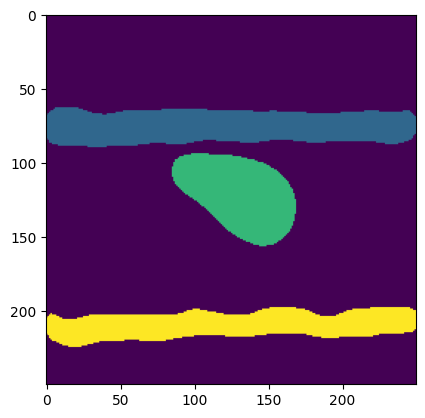

In [58]:
plt.imshow(masks[0])

In [36]:
def delete_all_files(path):
    for filename in os.listdir(path):
        file_path = os.path.join(path, filename)
        if os.path.isfile(file_path):
            os.remove(file_path)

In [41]:
def get_center_object_label(mask:np.ndarray) -> int:
    """
    Most centered object is the cell.
    (Problem: sometimes they aren't any cell)
    """
    # Step 1: Find the center of the mask
    center = np.array(mask.shape) / 2

    # Step 2: Get all unique object labels (excluding background 0)
    labels = np.unique(mask)
    labels = labels[labels != 0]

    # Step 3: Compute centroids of all objects
    centroids = ndimage.center_of_mass(mask, labels=mask, index=labels)

    # Step 4: Compute distances to the center
    distances = [np.linalg.norm(np.array(centroid) - center) for centroid in centroids]

    # Step 5: Find the label with the minimum distance
    closest_label = labels[np.argmin(distances)]
    return closest_label

    
save_cell_images_to = os.path.join(path_dataset, "..", "Parachute_extracted")
os.makedirs(save_cell_images_to, exist_ok=True)

delete_all_files(save_cell_images_to)

for filename, image, mask in zip(images_names, images, masks):

    label_at_center = mask[mask.shape[1]//2, mask.shape[0]//2]
    if label_at_center == 0:
        continue # No cell

    cell_mask = mask == label_at_center

    ys, xs = np.where(cell_mask)
    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()
    bbox = (x_min, y_min, x_max, y_max)
    width, height = x_max - x_min, y_max - y_min
    if abs(height/width - 1) > .5: 
        continue # Cells should be rough square, not rectangles

    cell = image[y_min:y_max, x_min:x_max]
    mask_slice = cell_mask[y_min:y_max, x_min:x_max]
    cell[mask_slice == 0] = 0

    Image.fromarray(cell).save(os.path.join(save_cell_images_to, filename))
    continue
    
    plt.figure(figsize=(20, 10))
    plt.subplot(141)
    plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    plt.subplot(142)
    plt.imshow(mask)
    plt.subplot(143)
    plt.imshow(cell_mask)
    plt.subplot(144)
    plt.imshow(cell, cmap='gray', vmin=0, vmax=255)
    plt.show()

# Slippers

In [61]:
path_dataset = os.path.join("..", "data", "2024_liang", "Slipper_zoomed")
images_names = os.listdir(path_dataset)
print(len(images_names))

248


In [66]:
images = [np.array(Image.open(os.path.join(path_dataset, iname))) for iname in images_names if iname.endswith("png")]

In [63]:
# Select only a subset of above for testing
N = 5
images = [np.array(Image.open(os.path.join(path_dataset, iname))) for iname in images_names[:N]  if iname.endswith("png")]
print(len(images))

5


In [67]:
masks = []

for image in tqdm(images):
    m, _, _, _ = model.eval(image, diameter=60, channels=[0,0],
                                         flow_threshold=0.4, do_3D=False)
    masks.append(m)
    
# masks is a list of np arrays

100%|██████████████████████████████| 248/248 [02:19<00:00,  1.77it/s]


In [68]:
def get_center_object_label(mask:np.ndarray) -> int:
    """
    Most centered object is the cell.
    (Problem: sometimes they aren't any cell)
    """
    # Step 1: Find the center of the mask
    center = np.array(mask.shape) / 2

    # Step 2: Get all unique object labels (excluding background 0)
    labels = np.unique(mask)
    labels = labels[labels != 0]

    # Step 3: Compute centroids of all objects
    centroids = ndimage.center_of_mass(mask, labels=mask, index=labels)

    # Step 4: Compute distances to the center
    distances = [np.linalg.norm(np.array(centroid) - center) for centroid in centroids]

    # Step 5: Find the label with the minimum distance
    closest_label = labels[np.argmin(distances)]
    return closest_label

    
save_cell_images_to = os.path.join(path_dataset, "..", "Slipper_extracted")
os.makedirs(save_cell_images_to, exist_ok=True)
def delete_all_files(path):
    for filename in os.listdir(path):
        file_path = os.path.join(path, filename)
        if os.path.isfile(file_path):
            os.remove(file_path)
delete_all_files(save_cell_images_to)

for filename, image, mask in tqdm(list(zip(images_names, images, masks))):

    # Convert RGBA to Gray
    image = cv2.cvtColor(image, cv2.COLOR_RGBA2GRAY)

    label_at_center = mask[mask.shape[1]//2, mask.shape[0]//2]
    if label_at_center == 0:
        continue # No cell

    cell_mask = mask == label_at_center

    ys, xs = np.where(cell_mask)
    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()
    bbox = (x_min, y_min, x_max, y_max)
    width, height = x_max - x_min, y_max - y_min
    if abs(height/width - 1) > .5: 
        continue # Cells should be rough square, not rectangles

    cell = image[y_min:y_max, x_min:x_max]
    mask_slice = cell_mask[y_min:y_max, x_min:x_max]
    cell[mask_slice == 0] = 0

    Image.fromarray(cell).save(os.path.join(save_cell_images_to, filename))
    continue
    
    plt.figure(figsize=(20, 10))
    plt.subplot(141)
    plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    plt.subplot(142)
    plt.imshow(mask)
    plt.subplot(143)
    plt.imshow(cell_mask)
    plt.subplot(144)
    plt.imshow(cell, cmap='gray', vmin=0, vmax=255)
    plt.show()

100%|████████████████████████████| 248/248 [00:00<00:00, 1064.68it/s]


# Creating test/train splits

In [69]:
# Load splits percentages in config
from omegaconf import DictConfig, OmegaConf
from hydra import initialize, compose
from random import sample
from shutil import copy2

with initialize(config_path="../conf", version_base="1.3"):
    cfg = compose(config_name="config")
    print(OmegaConf.to_yaml(cfg.splits))

liang_2024_split_test: 48
liang_2024_split_train: 48
liang_2024_split_val: 4
kihm_2018_split_test: 28
kihm_2018_split_train: 68
kihm_2018_split_val: 4
nouaman_2024_split_test: 48
nouaman_2024_split_train: 48
nouaman_2024_split_val: 4



In [70]:
path_test = os.path.join(cfg.paths.root_abs, cfg.paths.liang_2024_from_root, "test")
path_train = os.path.join(cfg.paths.root_abs, cfg.paths.liang_2024_from_root, "train")
path_val = os.path.join(cfg.paths.root_abs, cfg.paths.liang_2024_from_root, "val")
os.makedirs(path_test, exist_ok=True)
os.makedirs(path_train, exist_ok=True)
os.makedirs(path_val, exist_ok=True)
for subf in ("parachute", "slipper"):
    os.makedirs(os.path.join(path_test, subf), exist_ok=True)
    os.makedirs(os.path.join(path_train, subf), exist_ok=True)
    os.makedirs(os.path.join(path_val, subf), exist_ok=True)

path_source_parachute = os.path.join(cfg.paths.root_abs, cfg.paths.liang_2024_from_root, "Parachute_extracted")
path_source_slipper = os.path.join(cfg.paths.root_abs, cfg.paths.liang_2024_from_root, "Slipper_extracted")

In [71]:
for cell_type, path_source_type in [
    ('parachute', path_source_parachute), ('slipper', path_source_slipper)
]: 
    print(cell_type)

    nb_type = len(os.listdir(path_source_type))
    nb_train = int(nb_type *  cfg.splits.liang_2024_split_train / 100)
    nb_test = int(nb_type *  cfg.splits.liang_2024_split_test / 100)
    nb_val = int(nb_type *  cfg.splits.liang_2024_split_val / 100)
    print(f'    train: {nb_train}, test: {nb_test}, val:{nb_val}')
    
    cells = os.listdir(path_source_type)
    
    delete_all_files(os.path.join(path_train, cell_type))
    delete_all_files(os.path.join(path_test, cell_type))
    delete_all_files(os.path.join(path_val, cell_type))


    cells_train = sample(cells, nb_train)
    remaining = [f for f in os.listdir(path_source_type) if not f in cells_train]
    cells_test = sample(remaining, nb_test)
    cells_val = sample(
        [f for f in os.listdir(path_source_type) if not f in cells_train and not f in cells_test], 
        nb_val)
    
    for pname in cells_train:
        copy2(
            src=os.path.join(path_source_type, pname),
            dst=os.path.join(path_train, cell_type, pname)
        )

        
    for pname in cells_test:
        copy2(
            src=os.path.join(path_source_type, pname),
            dst=os.path.join(path_test, cell_type, pname)
        )
    for pname in cells_val:
        copy2(
            src=os.path.join(path_source_type, pname),
            dst=os.path.join(path_val, cell_type, pname)
        )


parachute
    train: 282, test: 282, val:23
slipper
    train: 91, test: 91, val:7
